## Update routine: 
Download THE from (from 10/2021 onward) and save as "THE_data.csv"
https://www.tradinghub.eu/en-gb/Publications/Transparency/Aggregated-consumption-data

Download Destatis Data for "Produktionsindex" and "Produktionsindex/Produzierendes Gewerbe"
https://www.destatis.de/DE/Themen/Wirtschaft/Konjunkturindikatoren/_inhalt.html

Download Eurostat data 
https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nrg_cb_pem&lang=en

Download hospitality sector and save as "hospitality_sector.csv"
 https://www.destatis.de/DE/Presse/Pressemitteilungen/2022/06/PD22_257_45213.html

Download retail sector and save as "retail_sector.csv"
https://www.destatis.de/DE/Presse/Pressemitteilungen/2022/06/PD22_225_45212.html;jsessionid=8FCA20B92037F6BCE9F9DB13AADAA111.live721

Generate ENTSO-E data and SLP (Jarusch) 

In [1]:
import os
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

In [3]:
start = pd.Timestamp("2017-01-01")
end = pd.Timestamp("2022-04-30")

# Aggregated demand data

In [4]:
def to_datetime(df, col_name):
    try:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))
    except:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y', utc=True))    
    df.index = df.index.date
    df.index = pd.to_datetime(df.index) 
    return df.index

## Trading Hub Europe: SLPs & RLMs

THE original data: https://www.tradinghub.eu/en-gb/Publications/Transparency/Aggregated-consumption-data

In [5]:
#read
the_new = pd.read_csv(os.path.join(data_path, "THE_data.csv"), sep=";")
the_new.index = to_datetime(the_new, "Gasday")

#to numeric
the_new = the_new[the_new.columns[~the_new.columns.isin(["Gastag", "Status", "Gasday", "State"])]].fillna("0")
the_new = the_new.iloc[::-1] 
the_new = the_new.apply(lambda x: x.apply(lambda y: float(y.replace(".", "").replace(",", ""))))

#from kWh to TWh
the_new = the_new / (10**9)

In [6]:
def sum_consumptions(df):
    return pd.concat([
        df[df.filter(like=domain, axis=1).columns].sum(1) for domain in ["SLP", "RLM"]
    ], axis = 1, keys = ["slp", "rlm"]
    )

<AxesSubplot:>

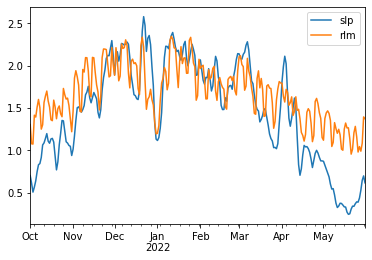

In [7]:
sum_consumptions(the_new).plot()

Gas pool data from: https://www.tradinghub.eu/de-de/Download/Archiv-GASPOOL / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [8]:
gaspool = pd.read_csv(os.path.join(data_path, "gaspool.csv"), sep=";")
gaspool.index = to_datetime(gaspool, "Datum")
gaspool.drop("Datum", axis=1, inplace=True)

#from MWh to TWh
gaspool = gaspool / (10**6)

<AxesSubplot:>

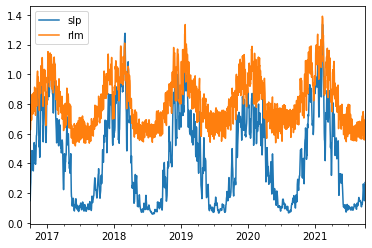

In [9]:
sum_consumptions(gaspool).plot()

NCG data from:https://www.tradinghub.eu/de-de/Download/Archiv-NetConnect-Germany / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [10]:
#in KWh
ncg = pd.read_csv(os.path.join(data_path, "ncg.csv"), sep=";")
ncg.index = to_datetime(ncg, "DayOfUse")

ncg.drop(["DayOfUse", "Status"], axis=1, inplace=True)
ncg.drop(list(ncg.filter(like='Unit', axis=1).columns), axis=1, inplace=True)

#from kWh to TWh
ncg = ncg / (10**9)

<AxesSubplot:>

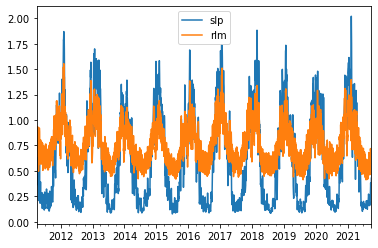

In [11]:
sum_consumptions(ncg).plot()

In [12]:
the = pd.concat([
    sum_consumptions(df) for df in [the_new, gaspool, ncg]
])
the = the.sort_index()
the = the.groupby(the.index).sum()

<AxesSubplot:>

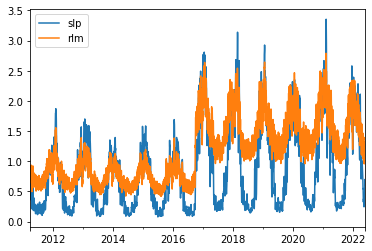

In [13]:
the.plot()

# Proxies / control variables / disaggregated demand
## Estimated SLP (when2heat: w2h)

In [14]:
w2h = pd.read_csv(os.path.join(data_path, "SLPs_test.csv"), index_col=0)
w2h.index = pd.to_datetime(
    pd.to_datetime(w2h.index).date
)
w2h = w2h[w2h.index.year>=2016]

In [15]:
w2h["commercial"] = w2h[["commercial_space TWh", "commercial_water TWh"]].sum(1)
w2h["residential"] = w2h[["residential_space TWh", "residential_water TWh"]].sum(1)

Gas consumption according to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [16]:
def scaling(df, target, target_year=2020): 
    return (df * target / df[df.index.year==target_year].sum()).copy()

In [17]:
w2h_scaled = pd.DataFrame()

scaling_map = {
    'residential': ('residential', 254),
    'commercial': ('commercial', 98),
    'decentral_chp': ('commercial', 15),
    'industry_buildings': ('commercial', 25)
}

for name_out, (name_in, target) in scaling_map.items():
    w2h_scaled[name_out] = scaling(w2h[name_in], target)
    
w2h_scaled['aggregated'] = w2h_scaled['residential'] + w2h_scaled['commercial']

In [18]:
w2h_scaled

,residential,commercial,decentral_chp,industry_buildings,aggregated
2017-01-01,1.643179,0.703716,0.107712,0.179519,2.346895
2017-01-02,1.600915,0.750379,0.114854,0.191423,2.351294
2017-01-03,1.527828,0.712065,0.108989,0.181649,2.239892
2017-01-04,1.459260,0.669649,0.102497,0.170829,2.128909
2017-01-05,1.622682,0.761677,0.116583,0.194305,2.384358
...,...,...,...,...,...
2022-05-27,0.342736,0.084062,0.012867,0.021444,0.426798
2022-05-28,0.456951,0.126798,0.019408,0.032346,0.583750
2022-05-29,0.580496,0.185968,0.028464,0.047441,0.766464
2022-05-30,0.616812,0.221374,0.033884,0.056473,0.838186


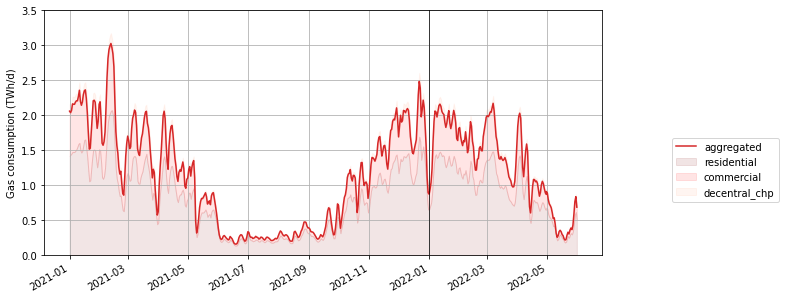

In [19]:
w2h_scaled.loc[w2h_scaled.index.year>=2021,'aggregated'].plot(color='tab:red', figsize=(10,5))
plt.grid()

estimated2021 = w2h_scaled.loc["2021-01-01":]

bottom = 0
for sector, c, label in [
    ("residential", "maroon", "residential"), 
    ("commercial","red", "commercial"), 
    ("decentral_chp", "lightsalmon", "decentral_chp") 
]:
    plt.fill_between(estimated2021.index, bottom, bottom+estimated2021[sector], color=c, alpha=0.1, label = label)
    bottom += estimated2021[sector]

plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.legend(loc='upper right', bbox_to_anchor=(1.325, 0.5))
plt.ylim(0, 3.5)
plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [20]:
#earlier data
el_update = pd.read_csv(os.path.join(data_path, "entsoe_old.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]
el_update.index = pd.to_datetime(
    el_update.index.map(lambda x: x.date())
)


#new data
electricity_from_gas = pd.read_csv(os.path.join(data_path, "entsoe_gas_new.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

electricity_from_gas.index = pd.to_datetime(
    pd.to_datetime(electricity_from_gas.index).date
)
electricity_from_gas = electricity_from_gas 

#concat

electricity_from_gas = pd.concat([
    el_update, electricity_from_gas.loc[el_update.index[-1]:]
                                       ], axis=0)


In [21]:
electricity_from_gas.to_csv("entsoe_old.csv")

Scaled to monthly Eurostat data on electricity generation from gas:

In [22]:
monthly_scaling = pd.read_csv(os.path.join(data_path, "nrg_cb_pem__custom_2931753_page_linear.csv"), 
                                   index_col="TIME_PERIOD", parse_dates=True)["OBS_VALUE"]
monthly_scaling.index = monthly_scaling.index = pd.to_datetime(
    pd.to_datetime(monthly_scaling.index).date
)
monthly_scaling = monthly_scaling / 1_000

In [23]:
monthly_scaling

2017-01-01    9.447693
2017-02-01    7.051090
2017-03-01    6.715718
2017-04-01    5.572014
2017-05-01    5.508734
                ...   
2021-12-01    7.848549
2022-01-01    8.120754
2022-02-01    6.272237
2022-03-01    7.839294
2022-04-01    5.694971
Name: OBS_VALUE, Length: 64, dtype: float64

In [24]:
for date in monthly_scaling.index:
    conditions = ((electricity_from_gas.index.year==date.year) & 
                  (electricity_from_gas.index.month==date.month))
    electricity_from_gas[conditions] = electricity_from_gas[conditions] * monthly_scaling[date] / electricity_from_gas[conditions].sum() 

Source: https://www.bdew.de/media/documents/Jahresbericht_2021_UPDATE_Juni_2022.pdf (p. 16)

In [25]:
gas_to_electricity_public = scaling(electricity_from_gas, 121, 2021)

gas_to_electricity_public.name = "gas_to_electricity_public"

gas_to_electricity_public[(gas_to_electricity_public.index.year == 2021)].sum()

121.00000000000003

In [26]:
gas_to_electricity = scaling(electricity_from_gas , 189)

gas_to_electricity_public_pp = scaling(electricity_from_gas, 106)

gas_to_electricity_public_chp = scaling(electricity_from_gas, 34)

electricity_from_gas.name = "electricity_from_gas"    
gas_to_electricity.name = "gas_to_electricity"  

(17167.0, 19112.0)

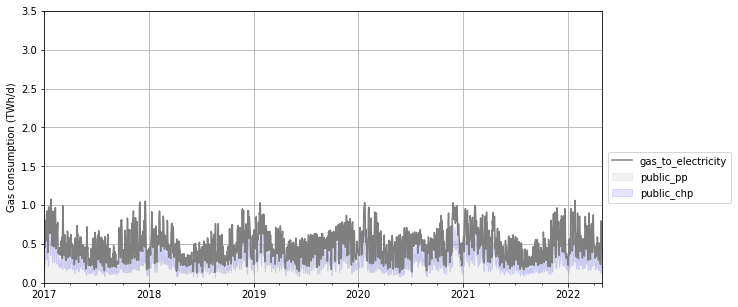

In [27]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()

plt.fill_between(gas_to_electricity_public_pp.index, 
                 0, 
                 gas_to_electricity_public_pp, 
                 color='grey', alpha=0.1, label="public_pp")
plt.fill_between(gas_to_electricity_public_pp.index, 
                 gas_to_electricity_public_pp, 
                 gas_to_electricity_public_pp+gas_to_electricity_public_chp, 
                 color='blue', alpha=0.1, label="public_chp")

plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.5))
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.xlim(left=start, right=end)

## Industrial gas consumption

Source: https://www.bdew.de/media/documents/Jahresbericht_2021_UPDATE_Juni_2022.pdf (p. 16)

In [28]:
industry = the['rlm'] - gas_to_electricity_public

industry.name = "industry"

industry = scaling(industry, 370, 2021)

industry[(industry.index.year == 2021)].sum()

370.0

In [29]:
the['slp'][(the['slp'].index.year == 2021)].sum() #pretty accurate (BDEW: households 310 TWh + commercial 129 TWh)

438.30048459299996

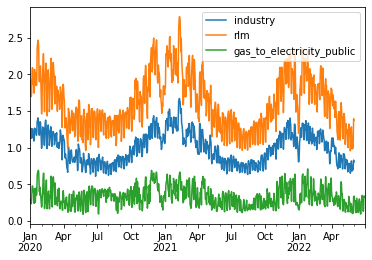

In [30]:
industry[industry.index.year >= 2020].plot()
the['rlm'][the['rlm'].index.year >= 2020].plot()
gas_to_electricity_public[gas_to_electricity_public.index.year >= 2020].plot()
plt.legend()

## Gas prices

In [31]:
gas_prices = pd.read_csv(os.path.join(data_path, "Dutch TTF Natural Gas Futures Recent.csv"), index_col=0)
gas_prices = gas_prices["Price"].to_frame().rename(columns={
    "Price":"gas_price [€/MWh]"}).dropna()
gas_prices.index = pd.to_datetime(pd.to_datetime(gas_prices.index, utc = True).date)

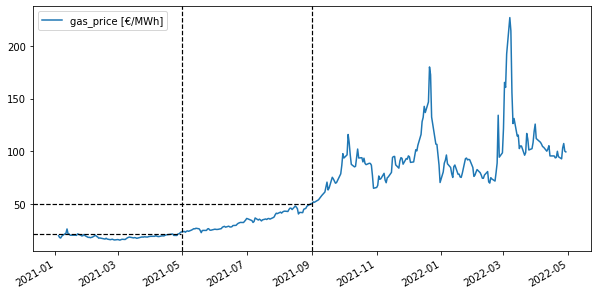

In [32]:
gas_prices.plot(figsize=(10,5))
plt.axvline(x="2021-09-1", color='k', linestyle='--', lw=1.2)
plt.axvline(x="2021-05-1", color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.5, y=50, color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.265, y=21, color='k', linestyle='--', lw=1.2)

In [33]:
def index_allignment(df):
    df.index = pd.DatetimeIndex(df.index)
    df = df.resample("D").mean()
    return df[df.index.duplicated()==False]

## Ambient temperature and solar radiation

In [34]:
# Currently only data from 2020 onwards


temperature = pd.read_csv(os.path.join(data_path, "temp.csv"), index_col=0)
temperature =  index_allignment(temperature)
temperature = temperature.rename(columns={"Temp [K]" : "temperature"})
temp_inertia = pd.read_csv('../data/temp_inertia.csv', index_col=0)
temp_inertia =  index_allignment(temp_inertia)
temp_inertia = temp_inertia.rename(columns={"Temp [K]" : "temp_inertia"})




solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar = index_allignment(solar)
solar = solar * 2.77778e-16 #J/d --> TWh/d
solar = solar.rename(columns={"solar [J/m^2]" : "solar"})

<AxesSubplot:xlabel='time'>

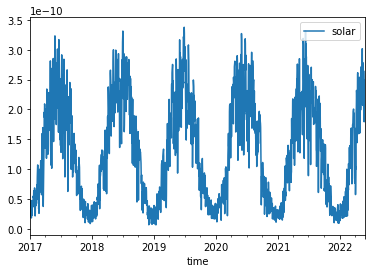

In [35]:
solar.plot()

## Economic activity

Source: https://www.destatis.de/DE/Themen/Wirtschaft/Konjunkturindikatoren/_inhalt.html

Producing sector: production index

In [36]:
producing_sector = pd.read_csv(os.path.join(data_path, "producing_sector.csv"), index_col=0, sep=";", dtype={"Kalender- und saisonbereinigt nach X13 JDemetra+":float}, decimal=",")
producing_sector = producing_sector.iloc[:,0] #0: original, 1: adjusted values

producing_sector.index = pd.DatetimeIndex(pd.DatetimeIndex(producing_sector.index).date)
producing_sector = producing_sector.reindex(the.index, method = "ffill")
producing_sector.name = "producing_sector"

Manufacturing sector: production index

In [37]:
manufacturing_sector = pd.read_csv(os.path.join(data_path, "manufacturing_sector.csv"), index_col=0, sep=";", dtype={"Originalwert":float}, decimal=",")
manufacturing_sector = manufacturing_sector.iloc[:,0] #0: original
#manufacturing_sector.index = manufacturing_sector.index.map(lambda x: pd.to_datetime(x.date, format='%d.%m.%Y'))
manufacturing_sector.index = pd.DatetimeIndex(pd.DatetimeIndex(manufacturing_sector.index).date)

manufacturing_sector = manufacturing_sector.reindex(the.index, method = "ffill")
manufacturing_sector.name = "manufacturing_sector"

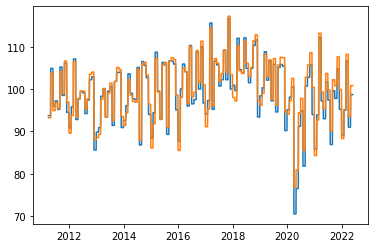

In [38]:
plt.plot(manufacturing_sector)
plt.plot(producing_sector)

Retail sector: sales index

Source: https://www.destatis.de/DE/Presse/Pressemitteilungen/2022/06/PD22_225_45212.html;jsessionid=8FCA20B92037F6BCE9F9DB13AADAA111.live721

In [39]:
retail_sector = pd.read_csv(os.path.join(data_path, "retail_sector.csv"), index_col=0, sep=";", dtype={"Reale Originalwerte":float}, decimal=",")
retail_sector = retail_sector.iloc[:,0] #0: original (real) 
retail_sector.index = retail_sector.index.map(lambda x: pd.to_datetime(x, format='%d.%m.%Y'))

retail_sector = retail_sector.reindex(the.index, method = "ffill")
retail_sector.name = "retail_sector"

Hospitality sector: sales index

Source: https://www.destatis.de/DE/Presse/Pressemitteilungen/2022/06/PD22_257_45213.html

In [40]:
hospitality_sector = pd.read_csv(os.path.join(data_path, "hospitality_sector.csv"), index_col=0, sep=";", dtype={"Originalwert":float}, decimal=",")
hospitality_sector = hospitality_sector.iloc[:,0] #0: original (real) 
hospitality_sector.index = hospitality_sector.index.map(lambda x: pd.to_datetime(x, format='%d.%m.%Y'))

hospitality_sector = hospitality_sector.reindex(the.index, method = "ffill")
hospitality_sector.name = "hospitality_sector"

# Combine data

In [41]:
df = the.join(
    [industry, gas_to_electricity_public, electricity_from_gas, gas_prices, producing_sector, manufacturing_sector, hospitality_sector, 
     retail_sector, w2h_scaled, solar, temperature, temp_inertia]
)

In [42]:
def unify_index(df):
    try:
        return df.loc[(df.index >= start) & (df.index <= end)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [43]:
df = unify_index(df).copy()

In [44]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [45]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [46]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [47]:
df.columns

Index(['slp', 'rlm', 'industry', 'gas_to_electricity_public',
       'electricity_from_gas', 'gas_price [€/MWh]', 'producing_sector',
       'manufacturing_sector', 'hospitality_sector', 'retail_sector',
       'residential', 'commercial', 'decentral_chp', 'industry_buildings',
       'aggregated', 'solar', 'temperature', 'temp_inertia', 'index', 'time',
       'year', 'month', 'weekday', 'weekday_num', 'monday', 'friday',
       'weekend', 'christmas_period', 'holiday', 'bridgeday'],
      dtype='object')

# Export

In [48]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))